In [53]:
import pandas as pd
import gzip
from io import BytesIO
import zipfile
import re
import numpy as np
import swifter
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import multiprocessing

## Loading the data

In [54]:
df_tweets_users = pd.read_csv('data/tweets_of_users.csv').dropna()
df_tweets_parties = pd.read_csv('data/tweets_of_praties.csv').dropna()

df_tweets_users['user_id'] = df_tweets_users['user_id'].astype(int)
df_tweets_parties['user_id'] = df_tweets_parties['user_id'].astype(int)

/Users/yogev/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
df_tweets_parties.head()

,user_id,party_en,created_at,text
0,1082167187006242817,Kahol_Lavan,Mon Apr 08 17:28:21 +0000 2019,ההודאה של סמוטריץ' על עסקה סודית עם נתניהו לקב...
1,1082167187006242817,Kahol_Lavan,Mon Apr 08 16:31:35 +0000 2019,אנשים מבינים מה הם צריכים לעשות. מבינים שחייבי...
2,1082167187006242817,Kahol_Lavan,Mon Apr 08 16:31:34 +0000 2019,אנחנו חצי מטר מהניצחון. אתמול היינו מטר. חייבי...
3,1082167187006242817,Kahol_Lavan,Mon Apr 08 14:32:22 +0000 2019,עוד 2 מנדטים לניצחון.\nכדי שברביעי נקום למציאו...
4,1082167187006242817,Kahol_Lavan,Mon Apr 08 11:25:17 +0000 2019,עוד 2 מנדטים לניצחון.\nכל קול קובע. אסור לבזבז...


In [56]:
df_tweets_users.head()

,user_id,name,screen_name,created_at,text
0,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 12:13:25 +0000 2019,@Irisleal15 @mmm08080556 איריס תודה. מדובר בבו...
1,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 12:02:53 +0000 2019,@Irisleal15 נראה לי שאת מייחסת חשיבות מועטה מד...
2,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 11:56:42 +0000 2019,@Irisleal15 איריס זה מקרה קלאסי של להרוג את הש...
3,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 10:51:46 +0000 2019,סטאלין שרצח מיליונים מבני עמו. דברי הבל וגם הס...
4,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 06:40:02 +0000 2019,@ShemuelMeir זה מונמארטר. הפוליטקניק הישן הוא ...


## # of accounts per party 

In [57]:
df_tweets_parties[['text', 'party_en','user_id']].groupby('party_en')['user_id'].nunique().sort_values(ascending=False)

party_en
Halikud             33
Haavoda             32
Kahol_Lavan         24
Shas                13
Kulanu              11
Hayemin_Hahadash    10
Zehut                9
Yahdut_Hatora        8
Ichud_Hayemin        8
Merez                7
Geshser              6
Israel_Beytenu       4
Hadash_Tal           3
Name: user_id, dtype: int64

## # of tweets per party

In [58]:
df_tweets_parties[['text', 'party_en']].groupby('party_en').count().sort_values(by=['text'],ascending=False)

,text
party_en,
Halikud,5753
Haavoda,5489
Kahol_Lavan,3384
Shas,2271
Kulanu,2139
Zehut,1517
Hayemin_Hahadash,1430
Merez,1400
Ichud_Hayemin,1355


## # of users 

In [59]:
print(f'Number of users is {df_tweets_users["user_id"].nunique()}')

Number of users is 7635


# Pre-processing

## Cleaning

In [60]:
def remove_links(text):
    return re.sub('http[s]?://\S+', '', str(text))

In [61]:
df_tweets_parties['clean_text'] = df_tweets_parties['text'].apply(remove_links)
df_tweets_users['clean_text'] = df_tweets_users['text'].apply(remove_links)

## Parties tweets augmantion and cancatination

In [62]:
mean_tweets_per_party = int(df_tweets_parties.groupby('party_en').count()['user_id'].mean())
print(f'Mean of tweets per party: {mean_tweets_per_party}')

Mean of tweets per party: 2145


In [63]:
def concat_text_with_mean_length(x):
    np.random.seed(0)
    ixs = np.random.randint(0, len(x.values), mean_tweets_per_party)
    tweet_list = x.values[ixs]
    
    return ''.join(tweet_list)

In [64]:
grouped = df_tweets_parties[['party_en', 'clean_text']].groupby('party_en')
df_concatenated_tweets_parties = grouped.agg({'clean_text': concat_text_with_mean_length})
df_concatenated_tweets_parties['clean_text_length'] = df_concatenated_tweets_parties['clean_text'].str.len()

In [65]:
df_concatenated_tweets_parties

,clean_text,clean_text_length
party_en,,
Geshser,@ishay_aderet @sefiova @tamarishshalom נו באמת...,191653
Haavoda,השימוע לבזן הוא מעט מדי מאוחר מדי. תושבי המפרץ...,204296
Hadash_Tal,"אישור בניית 31 יחידות דיור בגדה הכבושה בס""כ 22...",206889
Halikud,כל בוקר אני מתעורר ומקווה שמישהו יעצור את הטיר...,204135
Hayemin_Hahadash,RT @amit_segal: גוש הימין מטפס ל-63 מנדטים מאז...,197570
Ichud_Hayemin,שישי הקרוב # שבוע 8 # מפגן העוז למען הבנים# \n...,185863
Israel_Beytenu,@Omerdav @tamarzandberg @akivanovick לא אמרתי ...,206215
Kahol_Lavan,@LinoyBarGeffen בשם החופש עאלק. מעניין האם לשי...,189005
Kulanu,RT @GadiTaub1: קראתי היום ערימה של טוויטים שנו...,192618


## User's tweets cancatination

In [66]:
grouped = df_tweets_users[['user_id', 'clean_text']].groupby('user_id')
df_concatenated_tweets_users = grouped.agg({'clean_text': lambda x: ''.join(x.values)})
df_concatenated_tweets_users = df_concatenated_tweets_users.reset_index()
df_concatenated_tweets_users['user_id'] = df_concatenated_tweets_users['user_id'].astype(int)

In [67]:
df_concatenated_tweets_users.head()

,user_id,clean_text
0,5137,@yoosiiiiii @yullzi בשנות התשעים לא היו מודעים...
1,11080,"@Super_Dori אוקי אוקי, זה לא באמת 😁 פייק ניוז@..."
2,13164,@barzik @Gil__Mor @Haaretz זה כי אתה לא קורא ה...
3,14483,"RT @rikycohen4: שלחו לי עכשיו, העבירו הלאה! הת..."
4,17613,@LiSteinitz @DavidNevo3 הרי לשם זה התגייסה בכל...


## Zip utils

In [68]:
def zip_text(text):
    zip_buffer = BytesIO()
    with zipfile.ZipFile(zip_buffer, mode='w') as zf:
        zf.writestr('zip_file',text, zipfile.ZIP_DEFLATED) 
        
    return zip_buffer

def zip_and_wheight(text):
    return zip_text(text).getbuffer().nbytes

def party_text(party_name):
    return df_concatenated_tweets_parties[df_concatenated_tweets_parties.index == party_name]['clean_text'].values[0]

def zip_and_wheight_delta(text, party_name):
    AT_size = zip_text(party_text(party_name) + text).getbuffer().nbytes
    A_size = df_concatenated_tweets_parties[df_concatenated_tweets_parties.index == party_name]['orig_zip_size'].values[0]
        
    return AT_size - A_size


## Calculate concatenated tweets parties zip size

In [69]:
df_concatenated_tweets_parties['orig_zip_size'] = df_concatenated_tweets_parties['clean_text'].apply(zip_and_wheight)
df_concatenated_tweets_parties

,clean_text,clean_text_length,orig_zip_size
party_en,,,
Geshser,@ishay_aderet @sefiova @tamarishshalom נו באמת...,191653,79094
Haavoda,השימוע לבזן הוא מעט מדי מאוחר מדי. תושבי המפרץ...,204296,114271
Hadash_Tal,"אישור בניית 31 יחידות דיור בגדה הכבושה בס""כ 22...",206889,95200
Halikud,כל בוקר אני מתעורר ומקווה שמישהו יעצור את הטיר...,204135,119306
Hayemin_Hahadash,RT @amit_segal: גוש הימין מטפס ל-63 מנדטים מאז...,197570,99056
Ichud_Hayemin,שישי הקרוב # שבוע 8 # מפגן העוז למען הבנים# \n...,185863,96705
Israel_Beytenu,@Omerdav @tamarzandberg @akivanovick לא אמרתי ...,206215,88944
Kahol_Lavan,@LinoyBarGeffen בשם החופש עאלק. מעניין האם לשי...,189005,106952
Kulanu,RT @GadiTaub1: קראתי היום ערימה של טוויטים שנו...,192618,104681


## Calculate user-party delta zip size  

In [70]:
party_delta_column_names = [party for party in df_concatenated_tweets_parties.index]

In [74]:
# df_concatenated_tweets_users = df_concatenated_tweets_users[:1].copy()

In [108]:
def mp_worker(party_name):
    return (party_name,
            df_concatenated_tweets_users['clean_text'].swifter.apply(zip_and_wheight_delta, party_name=party_name))

def mp_handler():
    p = multiprocessing.Pool(2)
    return p.map(mp_worker, party_delta_column_names)

res = mp_handler()

Pandas Apply: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s]


In [109]:
for r in res:
    df_concatenated_tweets_users[r[0]] = r[1]

In [110]:
df_concatenated_tweets_users

,user_id,clean_text,Geshser,Haavoda,Hadash_Tal,Halikud,Hayemin_Hahadash,Ichud_Hayemin,Israel_Beytenu,Kahol_Lavan,Kulanu,Merez,Shas,Yahdut_Hatora,Zehut
0,5137,@yoosiiiiii @yullzi בשנות התשעים לא היו מודעים...,6265,6232,6209,6182,6169,6208,6205,6159,6176,6274,6310,6265,6104


In [169]:
%%time
for party_name in df_concatenated_tweets_parties.index:
    df_concatenated_tweets_users[party_name] = df_concatenated_tweets_users['clean_text'].swifter.apply(zip_and_wheight_delta, party_name=party_name)



Pandas Apply:   0%|          | 0/7635 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 4/7635 [00:00<03:17, 38.73it/s]

Pandas Apply:   0%|          | 7/7635 [00:00<03:38, 34.97it/s]

Pandas Apply:   0%|          | 11/7635 [00:00<03:45, 33.74it/s]

Pandas Apply:   0%|          | 14/7635 [00:00<03:58, 31.96it/s]

Pandas Apply:   0%|          | 17/7635 [00:00<04:04, 31.13it/s]

Pandas Apply:   0%|          | 20/7635 [00:00<04:15, 29.77it/s]

Pandas Apply:   0%|          | 23/7635 [00:00<04:20, 29.25it/s]

Pandas Apply:   0%|          | 26/7635 [00:00<04:18, 29.46it/s]

Pandas Apply:   0%|          | 30/7635 [00:00<04:16, 29.62it/s]

Pandas Apply:   0%|          | 33/7635 [00:01<04:18, 29.39it/s]

Pandas Apply:   0%|          | 36/7635 [00:01<04:17, 29.55it/s]

Pandas Apply:   1%|          | 39/7635 [00:01<04:17, 29.49it/s]

Pandas Apply:   1%|          | 43/7635 [00:01<04:16, 29.59it/s]

Pandas Apply:   1%|          | 46/7635 [00:01<07:14, 17.48it/s]

Pandas Apply:   1%|          | 49/

KeyboardInterrupt: 

In [168]:
%%time
for party_name in tqdm(df_concatenated_tweets_parties.index):
    df_concatenated_tweets_users[party_name] = df_concatenated_tweets_users['clean_text'].apply(zip_and_wheight_delta, party_name=party_name)


  0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
df_concatenated_tweets_users['prediction'] = df_concatenated_tweets_users[party_delta_column_names].idxmin(axis=1)

In [119]:
precentege_df = df_concatenated_tweets_users.groupby('prediction').count() / df_concatenated_tweets_users.count()[0]
df_concatenated_tweets_parties['precentege'] = precentege_df['user_id'] * 100
df_concatenated_tweets_parties['precentege'] = df_concatenated_tweets_parties['precentege'].fillna(0).astype(int)

In [120]:
df_concatenated_tweets_parties

,clean_text,clean_text_length,orig_zip_size,precentege
party_en,,,,
Geshser,@elirantal @arutz20 אלירן אל דאגה! אורלי לוי ת...,193596,78077,0
Haavoda,אלפי אנשים נשים וילדים גדשו את עשרות המניינים ...,204068,115103,18
Hadash_Tal,"שנה טובה, שנעשה אותה ביחד שנה של שותפות, תקווה...",207141,96170,0
Halikud,@naftalibennett חשוב מאד. כל הכבוד @naftaliben...,205462,119624,20
Hayemin_Hahadash,מסלול המורות החיילות החשוב כל כך יימשך. תודה ל...,201851,99374,6
Ichud_Hayemin,קשקוש שרי הקבינט!\nאחרי שהחמאס ירה היום ירי חי...,185028,95717,17
Israel_Beytenu,אני מברך את ועדת השרים לענייני חקיקה על אישור ...,205487,86448,0
Kahol_Lavan,@netanyahu תתערב ומנע את סגירת ההוסטלים של נוע...,188826,105709,7
Kulanu,@DayanNetanel @roysharon11 @azariarachel @mosh...,191961,103692,18


In [122]:
df_concatenated_tweets_users

,user_id,clean_text,Geshser,Haavoda,Hadash_Tal,Halikud,Hayemin_Hahadash,Ichud_Hayemin,Israel_Beytenu,Kahol_Lavan,Kulanu,Merez,Shas,Yahdut_Hatora,Zehut,prediction
0,780155,חשבתי על זה ואין לי שום אמפתיה כלפי שלדון אדלס...,10148,9863,10083,9896,9840,9990,10062,10011,10001,10161,10212,10074,9922,Hayemin_Hahadash
1,821962,@hkanji The story is about a startup that was ...,11161,10662,11012,10840,10795,10999,10802,10930,11072,11197,11272,10785,10771,Haavoda
2,1159931,RT @hang_gili: תקשיבו לא אכפת לי איך יראה האול...,11075,10910,11078,10943,10971,10919,11077,10970,11009,11098,11149,11140,10976,Haavoda
3,1415021,@MaropanitCohen @Riklin10 ואם יתברר שהוא סודני...,6616,6545,6638,6518,6497,6564,6692,6533,6529,6645,6655,6732,6522,Hayemin_Hahadash
4,2167291,@barzik יופי גאון. עכשיו חצי אומת הייטק תיכנס ...,8592,8476,8675,8526,8596,8530,8674,8533,8501,8639,8641,8675,8514,Haavoda
5,2472291,האח הגדול כבר פה? פיתוח ישראלי יאפשר למצוא אות...,8959,8829,8835,8836,8990,8823,8851,8931,8887,8855,8864,8909,8925,Ichud_Hayemin
6,3328201,@NaamaRak @Likud_Party תשלחי להם בחזרה @itaina...,6894,6883,6979,6845,6935,6842,6946,6863,6861,6925,6960,7024,6884,Ichud_Hayemin
7,3886711,הענקית האמריקאית אמזון מתכננת לשגר אלפי לוויינ...,10732,10684,10768,10677,10818,10704,10787,10778,10726,10713,10770,10822,10782,Halikud
8,3924941,@Jeronimo_ @maayanef אנחנו נשארים בלונדון בפסח...,10004,9458,9801,9662,9590,9801,9623,9848,9852,10115,10125,9591,9620,Haavoda
9,4378311,@SharonYosef There's nothing wrong with my han...,9539,9331,9526,9385,9314,9420,9492,9467,9446,9614,9651,9511,9311,Zehut


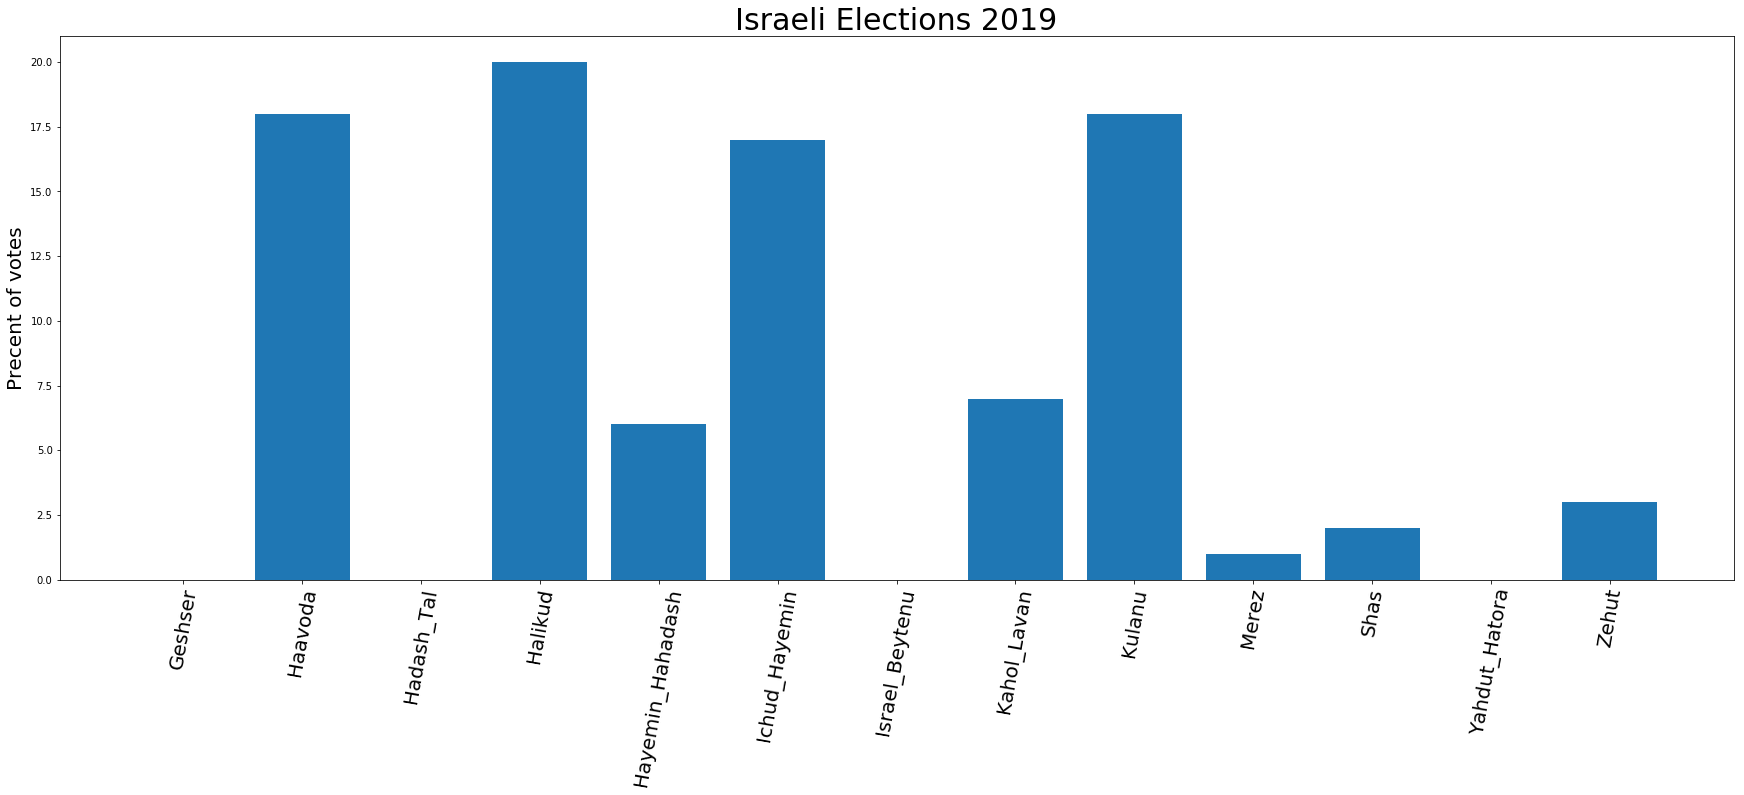

In [121]:
plt.figure(figsize=(30, 10))

label = party_delta_column_names
ys = df_concatenated_tweets_parties['precentege']
index = np.arange(len(label))
plt.bar(index, ys)
plt.ylabel('Precent of votes', fontsize=20)
plt.xticks(index, label, fontsize=20, rotation=80)
plt.title('Israeli Elections 2019', fontsize=30)
plt.show()